In [390]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

In [391]:
X = datasets.fetch_covtype().data[:3000]
y = datasets.fetch_covtype().target[:3000]
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train))  # 7分类任务

(2250, 54)
(2250,)
[1 2 3 4 5 6 7]


In [392]:
enc = OrdinalEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
print(np.unique(y_train_enc))
print(y_train_enc.shape)

[0. 1. 2. 3. 4. 5. 6.]
(2250, 1)


In [393]:
train_dataset = lgb.Dataset(data=X_train, label=y_train_enc)
val_dataset = lgb.Dataset(data=X_test, label=y_test_enc)

In [394]:
from sklearn.metrics import log_loss


def my_gbm_loss(y_pred, y_true):
    """lightgbm自定义验证数据集损失函数格式"""
    # 多分类任务中,y_pred先按类进行分组(比如前7个值是y_true[0]的预测值,最后7个值是y_true[-1]的预测值)
    reshape_y_pred = np.transpose(y_pred.reshape(7, -1))  # 这是一个7分类任务
    loss = log_loss(y_true.get_label(), reshape_y_pred)
    print("y_true.shape:{0},y_pred.shape:{1},reshape_y_pred.shape:{2}".format(y_true.get_label().shape, y_pred.shape,
                                                                              reshape_y_pred.shape))
    # 返回值格式:评估函数的名称(不含空格), 评估结果, 评估结果是否越高越高(比如AUC是越高越好,损失值是越低越好)
    return 'MY_GBM_LOSS', loss, False

In [395]:
params = {"objective": "multiclass",
          "num_class": 7,
          "verbose": -4, "metric": ("multi_logloss",)}

eval_set = [train_dataset, val_dataset]
evals_result = {}  # 储存评估指标结果

model = lgb.train(params=params,
                  train_set=train_dataset,
                  early_stopping_rounds=20,
                  # List of data to be evaluated on during training.
                  valid_sets=eval_set,
                  # This dictionary used to store all evaluation results of all the items in valid_sets.
                  evals_result=evals_result,
                  feval=my_gbm_loss)  # Customized evaluation function

# 预测结果为概率向量(多分类)
model.predict(X_test)

y_true.shape:(2250,),y_pred.shape:(15750,),reshape_y_pred.shape:(2250, 7)
y_true.shape:(750,),y_pred.shape:(5250,),reshape_y_pred.shape:(750, 7)
[1]	training's multi_logloss: 1.35453	training's MY_GBM_LOSS: 1.35453	valid_1's multi_logloss: 1.3728	valid_1's MY_GBM_LOSS: 1.3728
Training until validation scores don't improve for 20 rounds
y_true.shape:(2250,),y_pred.shape:(15750,),reshape_y_pred.shape:(2250, 7)
y_true.shape:(750,),y_pred.shape:(5250,),reshape_y_pred.shape:(750, 7)
[2]	training's multi_logloss: 1.16022	training's MY_GBM_LOSS: 1.16022	valid_1's multi_logloss: 1.20287	valid_1's MY_GBM_LOSS: 1.20287
y_true.shape:(2250,),y_pred.shape:(15750,),reshape_y_pred.shape:(2250, 7)
y_true.shape:(750,),y_pred.shape:(5250,),reshape_y_pred.shape:(750, 7)
[3]	training's multi_logloss: 1.0112	training's MY_GBM_LOSS: 1.0112	valid_1's multi_logloss: 1.08033	valid_1's MY_GBM_LOSS: 1.08033
y_true.shape:(2250,),y_pred.shape:(15750,),reshape_y_pred.shape:(2250, 7)
y_true.shape:(750,),y_pred.shape

C:\Users\duanm\anaconda3\lib\site-packages\lightgbm\basic.py:154: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


y_true.shape:(2250,),y_pred.shape:(15750,),reshape_y_pred.shape:(2250, 7)
y_true.shape:(750,),y_pred.shape:(5250,),reshape_y_pred.shape:(750, 7)
[19]	training's multi_logloss: 0.254998	training's MY_GBM_LOSS: 0.254998	valid_1's multi_logloss: 0.509865	valid_1's MY_GBM_LOSS: 0.509865
y_true.shape:(2250,),y_pred.shape:(15750,),reshape_y_pred.shape:(2250, 7)
y_true.shape:(750,),y_pred.shape:(5250,),reshape_y_pred.shape:(750, 7)
[20]	training's multi_logloss: 0.23812	training's MY_GBM_LOSS: 0.23812	valid_1's multi_logloss: 0.498223	valid_1's MY_GBM_LOSS: 0.498223
y_true.shape:(2250,),y_pred.shape:(15750,),reshape_y_pred.shape:(2250, 7)
y_true.shape:(750,),y_pred.shape:(5250,),reshape_y_pred.shape:(750, 7)
[21]	training's multi_logloss: 0.223249	training's MY_GBM_LOSS: 0.223249	valid_1's multi_logloss: 0.489582	valid_1's MY_GBM_LOSS: 0.489582
y_true.shape:(2250,),y_pred.shape:(15750,),reshape_y_pred.shape:(2250, 7)
y_true.shape:(750,),y_pred.shape:(5250,),reshape_y_pred.shape:(750, 7)
[22]	

array([[2.24275101e-02, 7.89586897e-01, 1.35757996e-03, ...,
        1.83641926e-01, 1.56184773e-03, 7.42595972e-04],
       [2.37174919e-04, 3.64995701e-04, 1.59266508e-03, ...,
        2.97279926e-04, 2.56359444e-04, 6.57052935e-05],
       [3.50194413e-02, 9.51106074e-01, 1.58755294e-03, ...,
        3.91254931e-03, 1.82580331e-03, 5.75094908e-03],
       ...,
       [8.96516543e-04, 5.74871743e-03, 2.15417195e-04, ...,
        9.91712540e-01, 1.23050796e-03, 1.02416259e-04],
       [2.61529957e-04, 4.22032309e-04, 9.95776958e-01, ...,
        3.29394780e-04, 2.91583442e-03, 7.29071736e-05],
       [3.03713082e-04, 1.07913076e-02, 1.56217250e-04, ...,
        9.88406765e-01, 1.79018948e-04, 8.49716945e-05]])

In [396]:
# 特征的相对重要性
model.feature_importance()

array([1585,  560,  344,  767,  618, 1272,  627,  556,  651, 1225,  103,
          0,   19,   35,   30,   17,    0,    0,   11,    0,    0,    0,
          0,   44,    0,  153,   30,    0,    0,    0,   23,    2,    0,
         51,    0,   11,   56,    1,    0,    0,    0,    0,   52,  100,
          0,    5,   11,    0,    0,    0,    0,    9,    7,    0])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

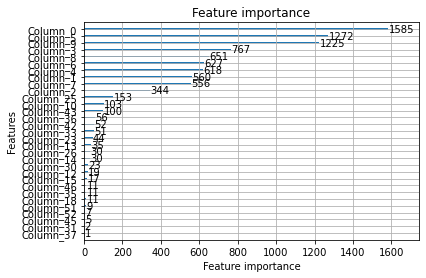

In [397]:
lgb.plot_importance(model)

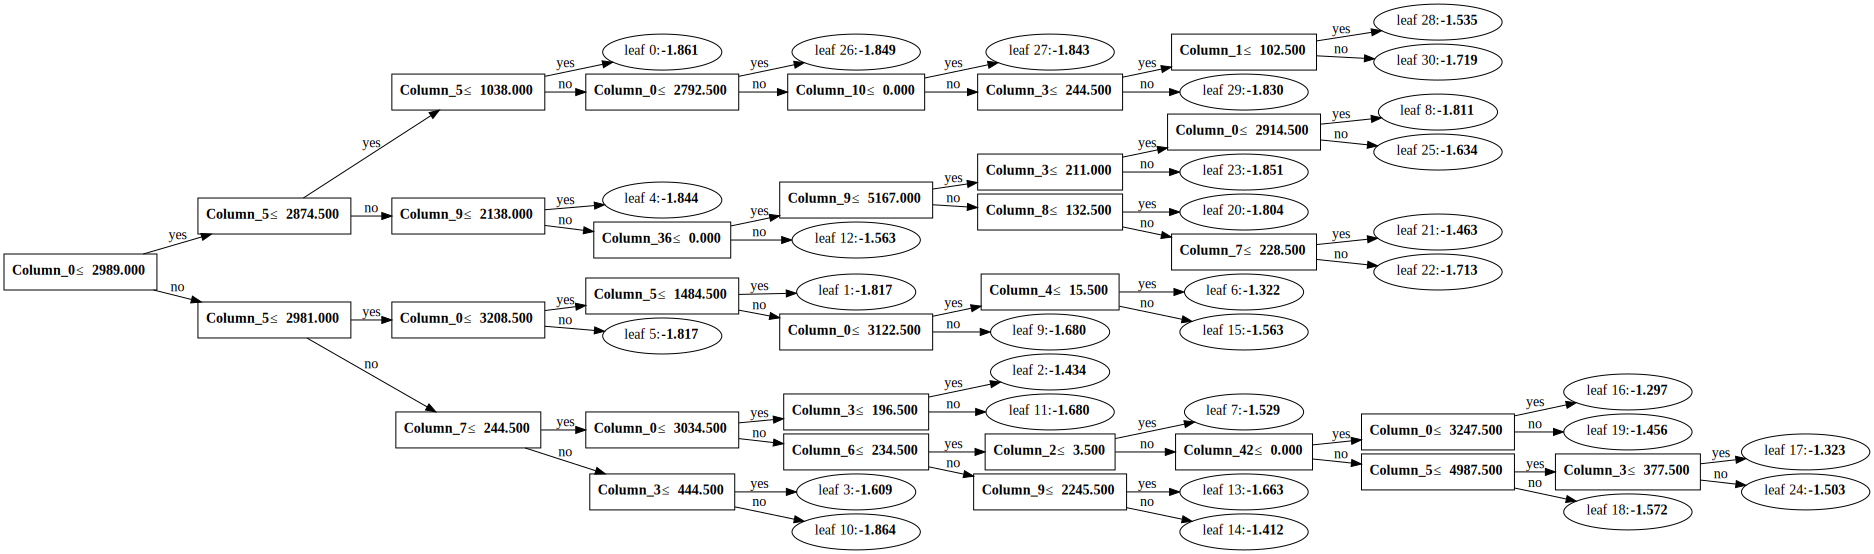

In [398]:
# 可视化lgb分割过程
img = lgb.create_tree_digraph(model)
img

In [399]:
type(img)

graphviz.dot.Digraph

In [400]:
evals_result

{'training': OrderedDict([('multi_logloss',
               [1.3545277112365839,
                1.1602176007499596,
                1.01120451496324,
                0.8954595468496976,
                0.8000313628525789,
                0.7202721460005852,
                0.6510208218778072,
                0.5915038913328897,
                0.5394956753462803,
                0.49518489635988266,
                0.455386954589998,
                0.420956685082877,
                0.3896167908662639,
                0.3614501456615976,
                0.3354911876368385,
                0.312888451173911,
                0.2919950305396037,
                0.2722259040031719,
                0.25499812726038495,
                0.23811962199960332,
                0.22324850023640067,
                0.2099862687383355,
                0.19668587075524097,
                0.18466144017266287,
                0.17440354867996505,
                0.16478746042778528,
                0

In [401]:
evals_result['training'].keys()

odict_keys(['multi_logloss', 'MY_GBM_LOSS'])

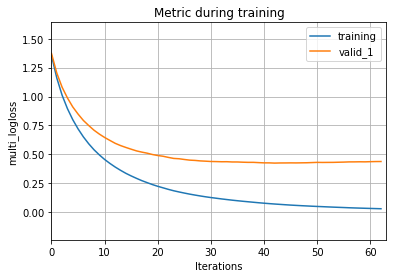

In [402]:
# Plot one metric during training.
ax = lgb.plot_metric(evals_result, metric='multi_logloss')  # multi_logloss指标绘制
plt.show()

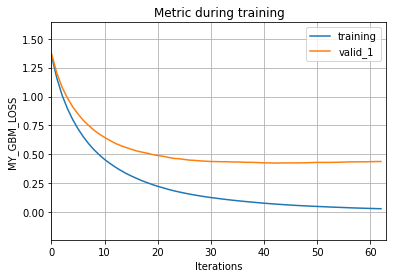

In [403]:
ax1 = lgb.plot_metric(evals_result, metric="MY_GBM_LOSS")  # MY_GBM_LOSS指标绘制
plt.show()